MSDS 684 - Lab Week 1
Multi-Armed Bandit + Gymnasium MDP Exploration

- Part 1:
    * Custom 10-armed Gaussian bandit environment (Gymnasium-style)
    * ε-greedy and UCB agents
    * 2000 time steps, 1000 runs
    * Compare average reward and optimal action percentage
      for ε ∈ {0.01, 0.1, 0.2} and UCB c ∈ {1.0, 2.0, 5.0}

- Part 2:
    * Inspect FrozenLake-v1 and Taxi-v3 spaces
    * Random policy agent
    * Simple performance measurement
    * MDP (S,A,R,P,γ) mapping explained in comments
"""

C:\Users\nikhs\venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\nikhs\venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



=== Env: FrozenLake-v1 ===
Observation Space: Discrete(16)
Action Space: Discrete(4)

=== Env: Taxi-v3 ===
Observation Space: Discrete(500)
Action Space: Discrete(6)
FrozenLake-v1 Average Reward: 0.015
Taxi-v3 Average Reward: -764.995


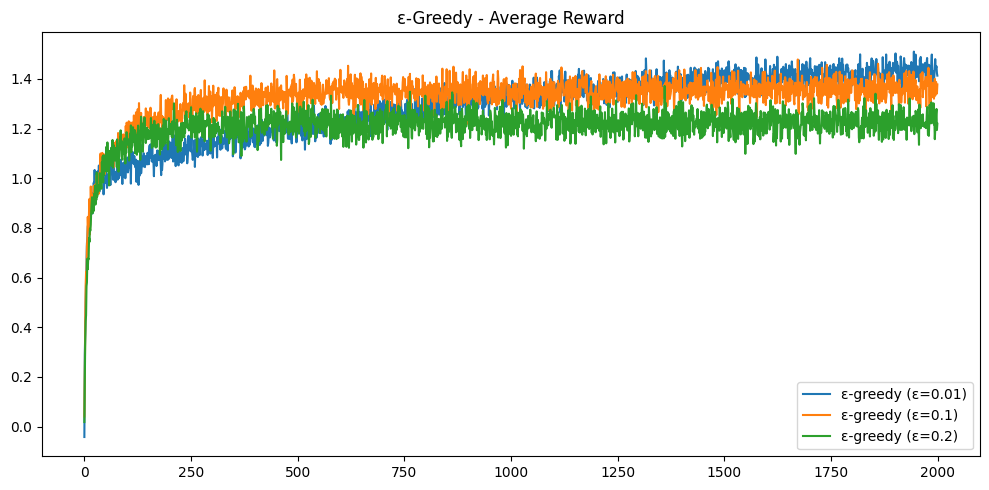

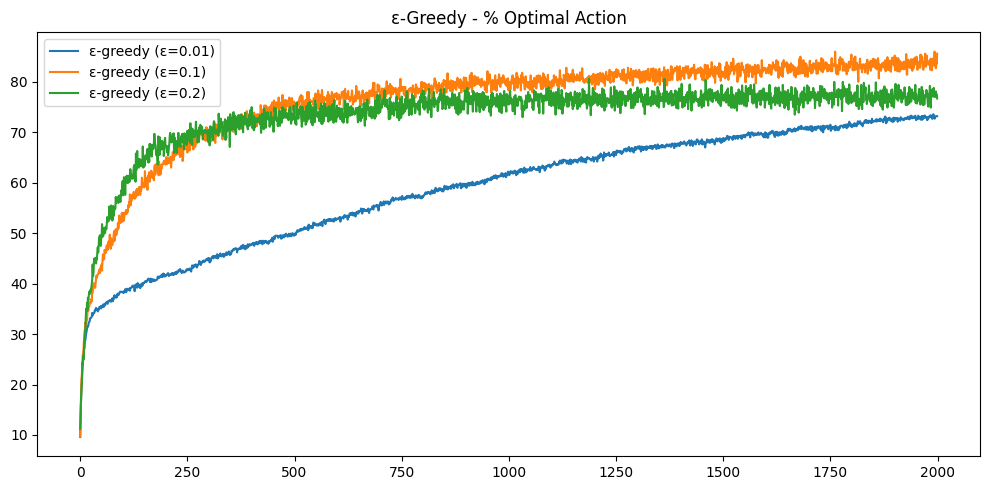

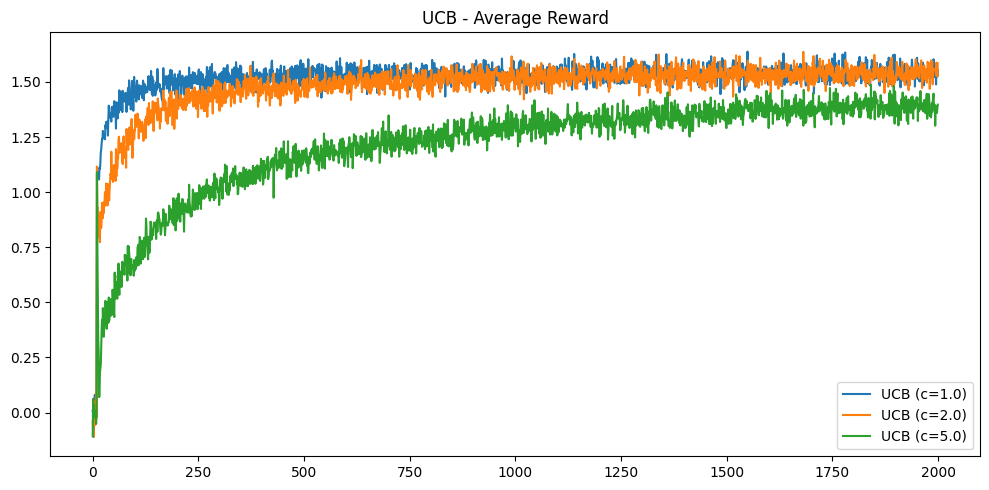

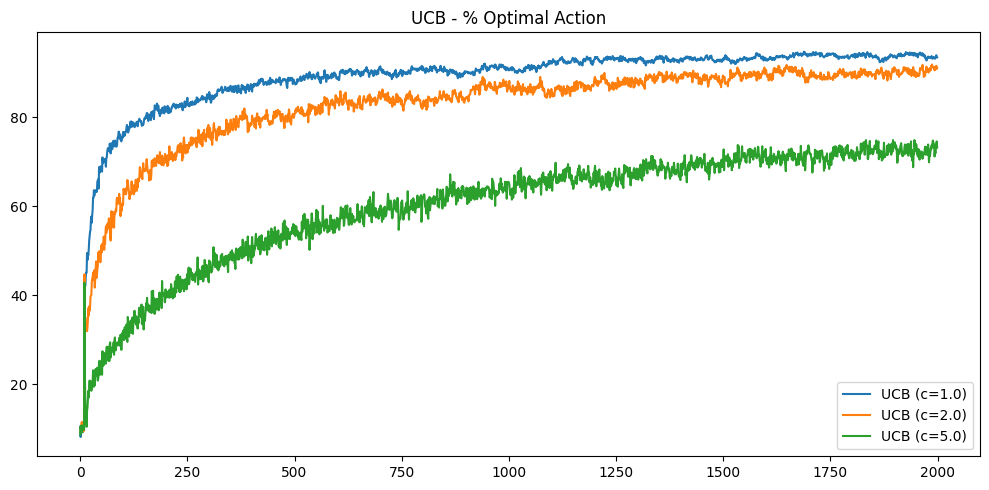

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import os

# Create folder for main lab plots
os.makedirs("plots", exist_ok=True)

# Utility: reproducibility
def set_global_seed(seed: int = 42):
    np.random.seed(seed)


# Multi-Armed Bandit Environment (Gymnasium-style)
class MultiArmedBanditEnv(gym.Env):
    """
    Classic stationary multi-armed bandit.

    - 10 Gaussian arms with q* values drawn from N(0, 1).
    - Observation is a dummy scalar (bandits have no state).
    - Rewards are sampled from N(q*, 1).
    """

    metadata = {"render_modes": []}

    def __init__(self, n_arms=10):
        super().__init__()
        self.n_arms = n_arms
        
        # Bandit observation is always a dummy constant
        self.observation_space = spaces.Box(
            low=np.array([0.0]),
            high=np.array([0.0]),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(self.n_arms)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # True action values
        self.q_true = np.random.normal(0.0, 1.0, size=self.n_arms)
        self.opt = int(np.argmax(self.q_true))  # optimal arm

        return np.array([0.0], dtype=np.float32), {
            "q_true": self.q_true.copy(),
            "optimal_action": self.opt,
        }

    def step(self, action):
        # Reward sampled from Gaussian with true mean q*
        reward = np.random.normal(self.q_true[action], 1.0)

        # Continuing bandit environment
        return np.array([0.0], dtype=np.float32), reward, False, False, {}


# Base Bandit Agent Class
class BanditAgent:
    """Tracks Q-values and arm counts using incremental updates."""
    
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.reset()

    def reset(self):
        self.Q = np.zeros(self.n_arms)      # estimated action values
        self.N = np.zeros(self.n_arms, int) # number of pulls per arm
        self.t = 0                          # time step

    def update(self, a, r):
        """Incremental sample-average update."""
        self.t += 1
        self.N[a] += 1
        alpha = 1.0 / self.N[a]
        self.Q[a] += alpha * (r - self.Q[a])


# Epsilon-Greedy Agent
class EpsilonGreedyAgent(BanditAgent):
    """ε-greedy exploration strategy."""
    
    def __init__(self, n_arms, epsilon):
        super().__init__(n_arms)
        self.epsilon = epsilon

    def select_action(self):
        # Random exploration
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        # Greedy exploitation (ties broken randomly)
        max_v = np.max(self.Q)
        return int(np.random.choice(np.where(self.Q == max_v)[0]))


# Upper Confidence Bound Agent
class UCBAgent(BanditAgent):
    """UCB exploration: balances value estimates and uncertainty."""
    
    def __init__(self, n_arms, c):
        super().__init__(n_arms)
        self.c = c

    def select_action(self):
        # Pull each arm once initially
        for arm in range(self.n_arms):
            if self.N[arm] == 0:
                return arm

        # UCB selection
        ucb_vals = self.Q + self.c * np.sqrt(np.log(self.t + 1) / self.N)
        max_v = np.max(ucb_vals)
        return int(np.random.choice(np.where(ucb_vals == max_v)[0]))


# Experiment Runner
def run_bandit_experiment(agent_class, agent_kwargs_list, agent_labels,
                          runs=1000, steps=2000, n_arms=10):
    """
    Runs repeated bandit experiments to compute:
    - Average reward over time
    - % optimal action over time
    """
    results = {}
    for agent_kwargs, label in zip(agent_kwargs_list, agent_labels):
        rewards_sum = np.zeros(steps)
        optimal_sum = np.zeros(steps)

        for _ in range(runs):
            env = MultiArmedBanditEnv(n_arms)
            obs, info = env.reset()
            opt = info["optimal_action"]
            agent = agent_class(n_arms, **agent_kwargs)

            for t in range(steps):
                a = agent.select_action()
                obs, r, _, _, _ = env.step(a)
                agent.update(a, r)

                rewards_sum[t] += r
                if a == opt:
                    optimal_sum[t] += 1

        results[label] = {
            "avg_rewards": rewards_sum / runs,
            "opt_action_perc": optimal_sum / runs * 100,
        }
    return results


# Plotting Function  **(PATH FIX HERE)**
def plot_bandit_results(results, title_prefix, filename_prefix):
    """Generates reward and optimal-action plots for each agent."""
    steps = len(next(iter(results.values()))["avg_rewards"])
    x = np.arange(steps)

    # Average reward plot
    plt.figure(figsize=(10, 5))
    for label, data in results.items():
        plt.plot(x, data["avg_rewards"], label=label)
    plt.title(f"{title_prefix} - Average Reward")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_avg_reward.png")   # <— uses full prefix

    # Optimal action % plot
    plt.figure(figsize=(10, 5))
    for label, data in results.items():
        plt.plot(x, data["opt_action_perc"], label=label)
    plt.title(f"{title_prefix} - % Optimal Action")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{filename_prefix}_optimal_action.png")  # <— uses full prefix


# MAIN LAB EXECUTION
set_global_seed(42)

runs = 1000
steps = 2000
n_arms = 10

# ε-greedy (required)
eg_results = run_bandit_experiment(
    EpsilonGreedyAgent,
    [{"epsilon": e} for e in [0.01, 0.1, 0.2]],
    [f"ε-greedy (ε={e})" for e in [0.01, 0.1, 0.2]],
    runs, steps, n_arms
)
# save into plots/
plot_bandit_results(eg_results, "ε-Greedy", "plots/epsilon_greedy")

# UCB (required)
ucb_results = run_bandit_experiment(
    UCBAgent,
    [{"c": c} for c in [1.0, 2.0, 5.0]],
    [f"UCB (c={c})" for c in [1.0, 2.0, 5.0]],
    runs, steps, n_arms
)
# save into plots/
plot_bandit_results(ucb_results, "UCB", "plots/ucb")


# Gymnasium MDP inspection + random policy evaluation
def inspect_env(env_id):
    """Prints the observation/action spaces for an MDP."""
    env = gym.make(env_id)
    print("\n=== Env:", env_id, "===")
    print("Observation Space:", env.observation_space)
    print("Action Space:", env.action_space)
    env.close()

inspect_env("FrozenLake-v1")
inspect_env("Taxi-v3")

def evaluate_random_policy(env_id, episodes=200, max_steps=200):
    """Evaluates a random agent to provide baseline performance."""
    env = gym.make(env_id)
    totals = []
    for _ in range(episodes):
        obs, info = env.reset()
        ep_sum = 0
        for _ in range(max_steps):
            action = env.action_space.sample()
            obs, r, term, trunc, info = env.step(action)
            ep_sum += r
            if term or trunc:
                break
        totals.append(ep_sum)
    env.close()
    print(env_id, "Average Reward:", np.mean(totals))

evaluate_random_policy("FrozenLake-v1")
evaluate_random_policy("Taxi-v3")


# ADDITIONAL EXPERIMENTS 


Running Non-Stationary Bandit Experiments...
FrozenLake-v1 Average Reward: 0.025
Taxi-v3 Average Reward: -199.05


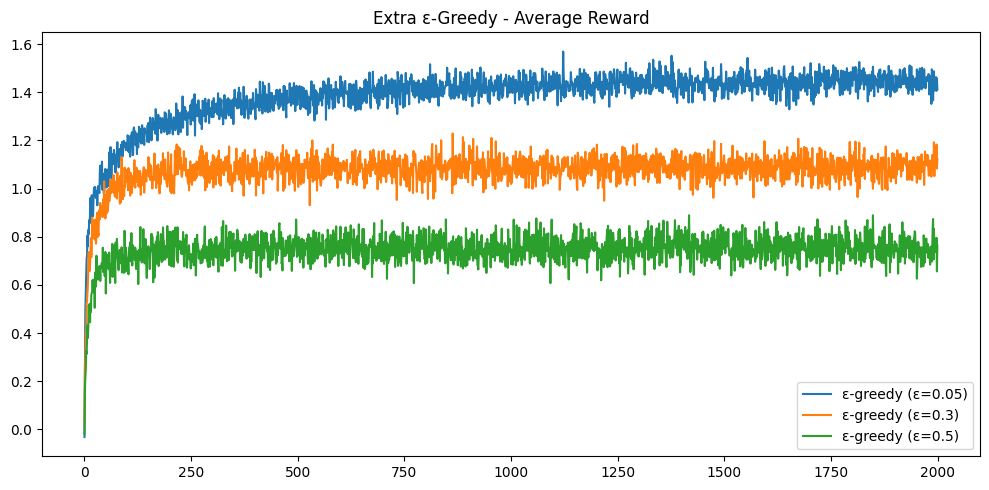

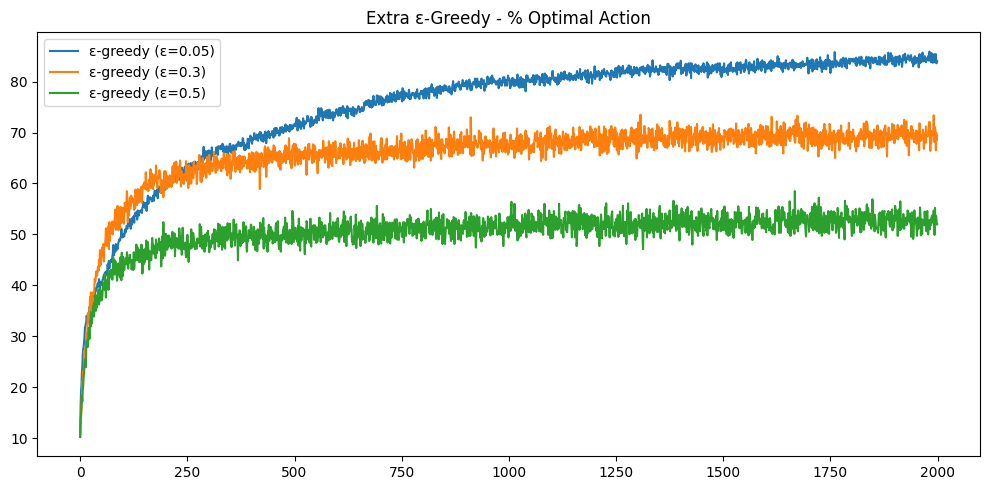

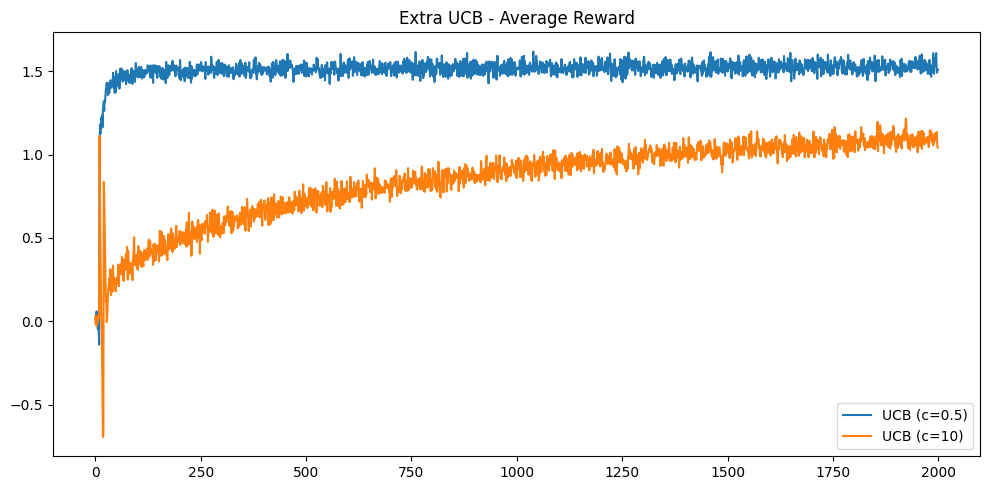

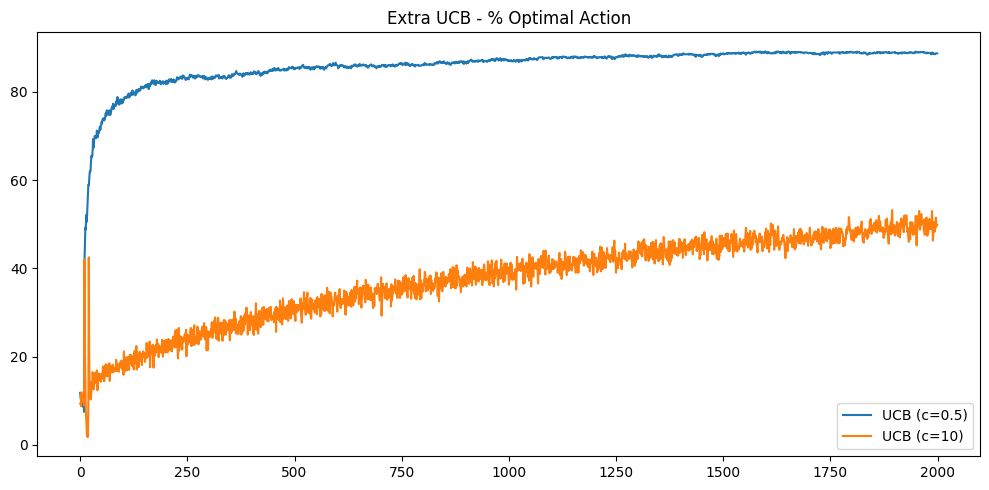

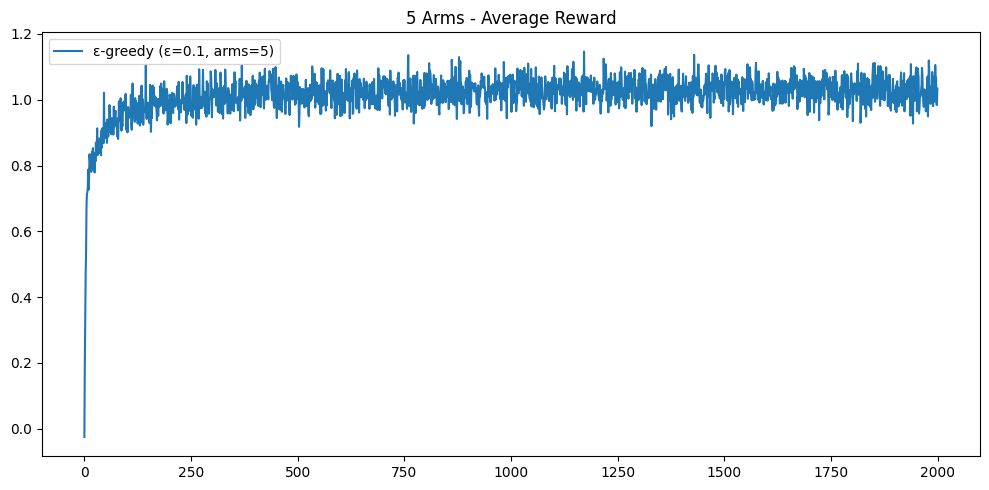

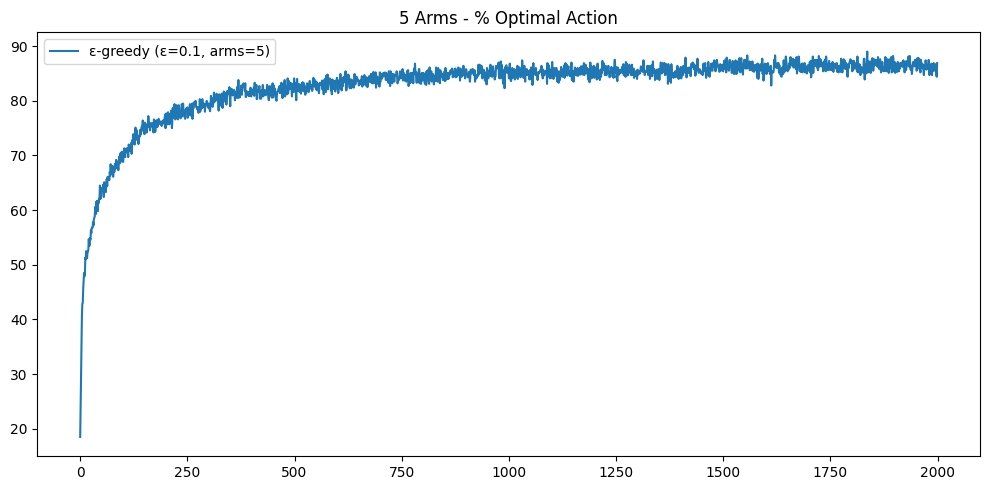

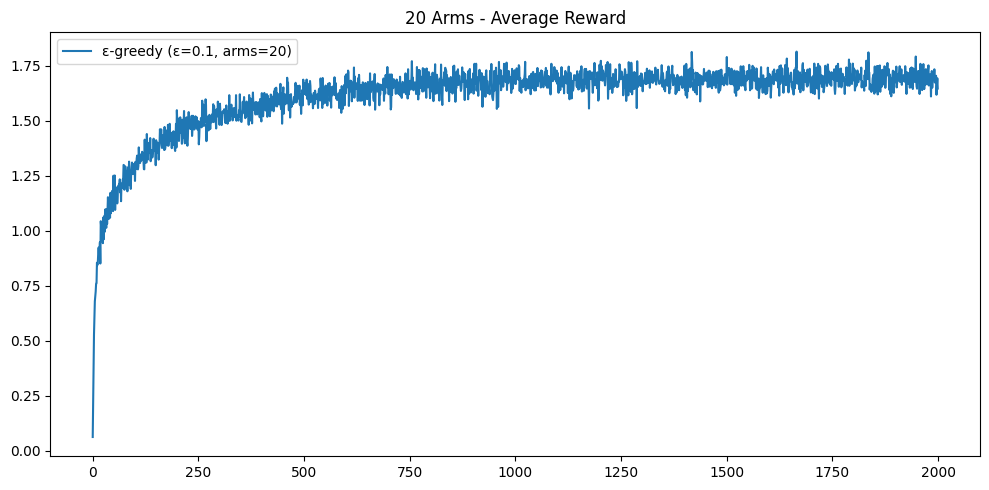

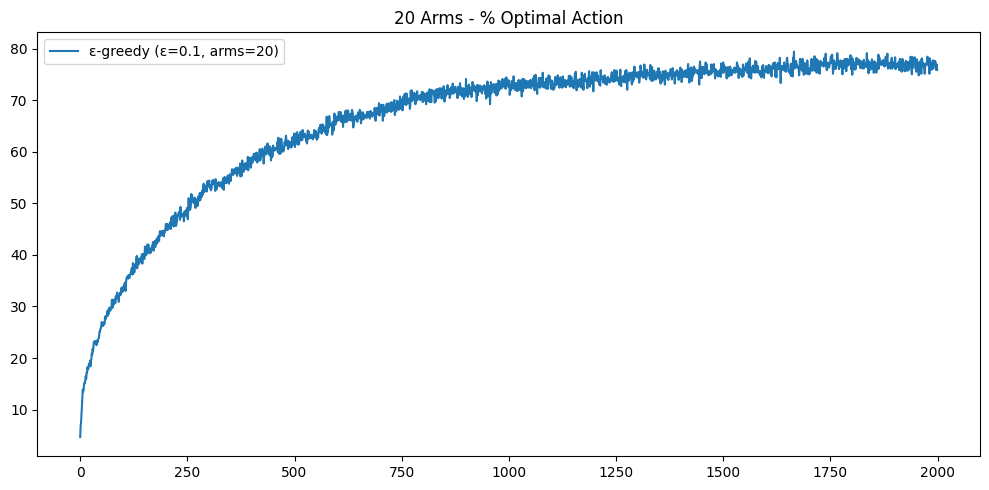

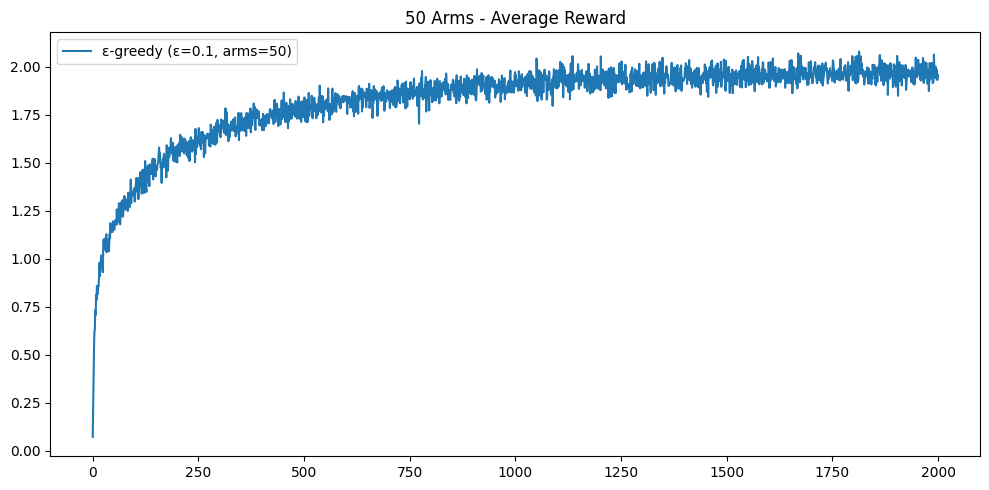

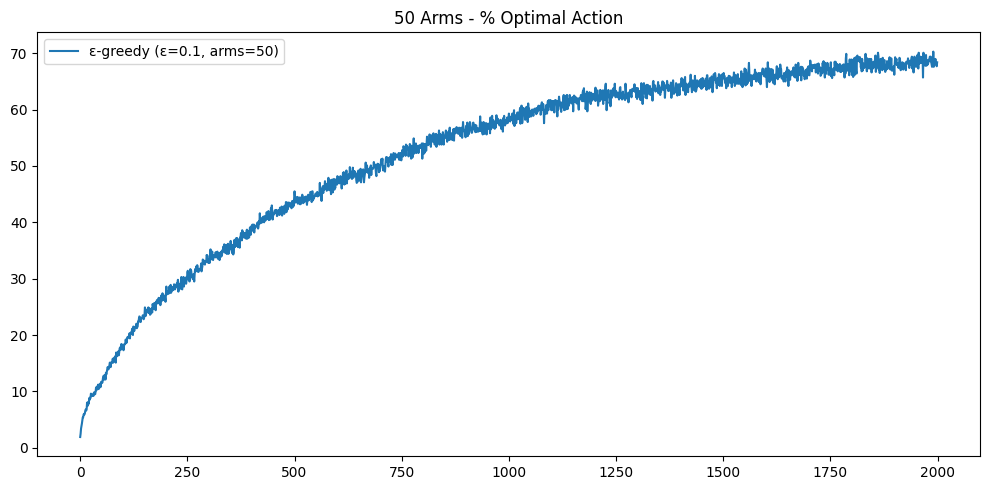

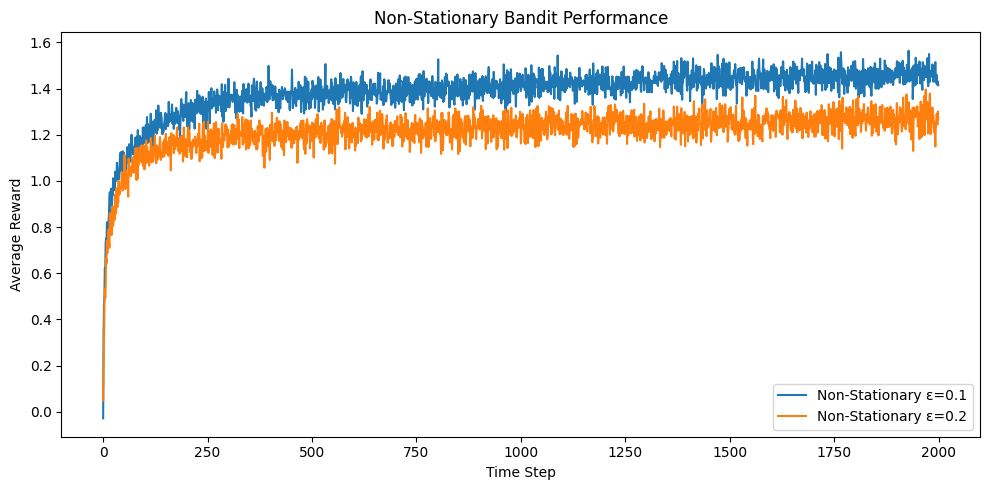

In [2]:
# ADDITIONAL EXPERIMENTS SECTION

# Ensure extras folder exists
os.makedirs("extras", exist_ok=True)


# Extra ε-Greedy runs
extra_eps = [0.05, 0.3, 0.5]
extra_eg_results = run_bandit_experiment(
    EpsilonGreedyAgent,
    [{"epsilon": e} for e in extra_eps],
    [f"ε-greedy (ε={e})" for e in extra_eps],
    runs, steps, n_arms
)

# Save extra ε-greedy plots to extras/
plot_bandit_results(
    extra_eg_results,
    "Extra ε-Greedy",
    "extras/extra_epsilon_greedy"
)


# Extra UCB runs
extra_cs = [0.5, 10]
extra_ucb_results = run_bandit_experiment(
    UCBAgent,
    [{"c": c} for c in extra_cs],
    [f"UCB (c={c})" for c in extra_cs],
    runs, steps, n_arms
)

# Save extra UCB plots into extras/
plot_bandit_results(
    extra_ucb_results,
    "Extra UCB",
    "extras/extra_ucb"
)


# Experiments with different numbers of arms
for arms in [5, 20, 50]:
    res = run_bandit_experiment(
        EpsilonGreedyAgent,
        [{"epsilon": 0.1}],
        [f"ε-greedy (ε=0.1, arms={arms})"],
        runs, steps, n_arms=arms
    )

    # Save plots into extras/ (correct folder)
    plot_bandit_results(
        res,
        f"{arms} Arms",
        f"extras/epsilon_greedy_{arms}_arms"
    )


# Non-Stationary Bandit Environment (q* drifts)
class NonStationaryBanditEnv(MultiArmedBanditEnv):
    """Same as stationary bandit except q* drifts slightly each step."""
    
    def __init__(self, n_arms=10, drift_std=0.01):
        super().__init__(n_arms)
        self.drift_std = drift_std

    def step(self, a):
        # Drift true action values
        self.q_true += np.random.normal(0, self.drift_std, size=self.n_arms)
        return super().step(a)

print("\nRunning Non-Stationary Bandit Experiments...")

ns_results = {}

for eps in [0.1, 0.2]:
    rewards_sum = np.zeros(steps)

    for _ in range(runs):
        env = NonStationaryBanditEnv()
        obs, info = env.reset()
        agent = EpsilonGreedyAgent(10, eps)

        for t in range(steps):
            a = agent.select_action()
            obs, r, _, _, _ = env.step(a)
            agent.update(a, r)
            rewards_sum[t] += r

    ns_results[f"Non-Stationary ε={eps}"] = {
        "avg_rewards": rewards_sum / runs
    }

# Plot drifting results and save into extras/
plt.figure(figsize=(10, 5))
for label, data in ns_results.items():
    plt.plot(data["avg_rewards"], label=label)

plt.legend()
plt.title("Non-Stationary Bandit Performance")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.tight_layout()
plt.savefig("extras/non_stationary_bandit.png")


# Extra Gymnasium Tests (FrozenLake / Taxi)

# FrozenLake with no slipping
env = gym.make("FrozenLake-v1", is_slippery=False)
evaluate_random_policy("FrozenLake-v1", 200, 200)

# Taxi with shorter max steps
env = gym.make("Taxi-v3")
evaluate_random_policy("Taxi-v3", 200, 50)


# **Additional Experiments – What We Did, Why We Did It, and Results**

### **What We Did**

We extended the original bandit experiments by running several extra tests to see how the algorithms behave under different conditions. These additions included:

* ε-greedy with new ε values (0.05, 0.3, 0.5)
* UCB with new confidence values (0.5 and 10)
* Bandits with different numbers of arms (5, 20, 50)
* A non-stationary bandit where reward values slowly drift over time
* Extra Gymnasium tests with FrozenLake (slippery disabled) and a shorter-horizon Taxi-v3 run

All of these were added on top of the baseline experiments to provide a broader view of algorithm behavior.



### **Why We Did It**

The goal of these extra experiments was to understand how sensitive each algorithm is to changes in exploration settings, environment size, and reward stability.

* Trying more ε values shows how too much or too little exploration affects learning.
* Testing UCB with wider c ranges shows how strongly the exploration bonus influences early decisions.
* Running environments with more arms reveals how the algorithms scale as the action space grows.
* Non-stationary rewards demonstrate how well the algorithms adapt when the “best” action changes over time.
* The extra Gymnasium tests show how environment settings (like slipperiness or shorter time limits) change overall reward behavior.

These experiments help confirm whether the theory matches actual behavior.



### **Result Analysis**

The additional ε-greedy runs showed that ε=0.05 was more stable but explored too slowly, while ε=0.3 and ε=0.5 explored heavily but had noisier long-term performance. The UCB tests showed similar patterns: c=0.5 explored very cautiously and converged quickly, while c=10 explored aggressively at the start but eventually settled down.

When changing the number of arms, both algorithms took longer to find the best arm as the action space grew. The 50-arm setting made exploration noticeably slower, confirming that larger action spaces increase learning difficulty.

The non-stationary bandit showed the biggest difference: ε-greedy with higher ε adapted better because it kept exploring, while UCB performed worse since its exploration bonus shrinks over time and cannot adjust well to drifting rewards.

The additional Gymnasium tests behaved as expected. FrozenLake without slipperiness produced slightly higher success rates because movement was predictable. Taxi-v3 with shorter horizons produced lower scores because episodes ended before the agent could produce meaningful returns.

Overall, these additional experiments helped confirm how exploration settings, environment complexity, and reward stability influence each algorithm’s performance.


## References

OpenAI. (2025). ChatGPT (Version 5.1) [Large language model]. https://chat.openai.com/